## Setup

In [1]:
import tensorflow as tf
import numpy as np
import math

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from util import import_dataset

address = '../../data/'
file_names = {}
file_names['images'] = 'full_data.npy'
file_names['subs'] = 'full_subredditlabels'
file_names['dict'] = 'full_subredditIndex'
file_names['nsfw'] = 'full_nsfwlabels'
data, dictionary = import_dataset(address, file_names)

In [3]:
print(data.X_train.shape)
print(data.X_val.shape)
print(data.X_test.shape)
print(data.y_train.shape)
print(data.y_val.shape)
print(data.y_test.shape)

(25450, 128, 128, 3)
(3181, 128, 128, 3)
(3182, 128, 128, 3)
(25450,)
(3181,)
(3182,)


## Run the Model

In [4]:
from googlenet import GoogleNet
from config import ModelConfig, TrainConfig

tf.reset_default_graph()

model_config = ModelConfig(eval_batch_size=3000, learning_rate=3.133e-4, output="nsfw", keep_prob=0.649)
train_config = TrainConfig(print_every=100, num_epochs=30, saver_address=r'../../saved_params/', \
    save_file_name = 'GoogleNet_nsfw_classification_3e-4_97', lr_decay=0.972)
model = GoogleNet(model_config)
sess = tf.Session()
model.train(data, sess, train_config)

---------------------------------------------------------
Batch 100/398 of epoch 1 finished in 19.061676 seconds
Batch 200/398 of epoch 1 finished in 17.240197 seconds
Batch 300/398 of epoch 1 finished in 17.329172 seconds
Epoch 1 training finished in 71.152685 seconds
train accuracy:90.8%
val accuracy:90.8%
Epoch 1 evaluation finished in 22.294206 seconds
---------------------------------------------------------
Batch 100/398 of epoch 2 finished in 17.322613 seconds
Batch 200/398 of epoch 2 finished in 17.314285 seconds
Batch 300/398 of epoch 2 finished in 17.310078 seconds
Epoch 2 training finished in 68.873140 seconds
train accuracy:91.7%
val accuracy:91.7%
Epoch 2 evaluation finished in 11.025997 seconds
---------------------------------------------------------
Batch 100/398 of epoch 3 finished in 17.299052 seconds
Batch 200/398 of epoch 3 finished in 17.322278 seconds
Batch 300/398 of epoch 3 finished in 17.284617 seconds
Epoch 3 training finished in 68.764338 seconds
train accura

## Load the Model

In [7]:
from googlenet import GoogleNet
from config import ModelConfig, TrainConfig
import pickle

# Reset Graph
tf.reset_default_graph()

# Create model instance
model_config = ModelConfig(output="nsfw")
model = GoogleNet(model_config)

# Load Saved Model
sess = tf.Session()
saver = tf.train.Saver()
save_file = "../../saved_params/GoogleNet_nsfw_classification_3e-4_97"
saver.restore(sess, save_file) 
saved_history = pickle.load(open(save_file + "_modelhist", 'rb'))
model.model_history = saved_history

# Test Model Accuracy
loss_train, acc_train = model.eval(data, sess, split='train')
loss_val, acc_val = model.eval(data, sess, split = 'val')

train accuracy:98.9%
val accuracy:95.8%


## Plot Graphs

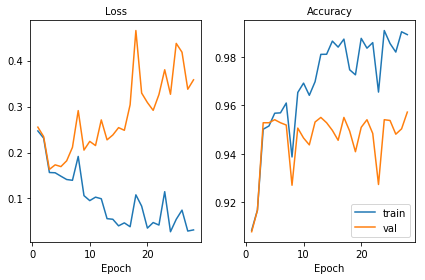

In [8]:
model.plot_loss_acc(data)

## Hyperparameter Optimization

In [10]:
from googlenet import GoogleNet
from config import ModelConfig, TrainConfig
import pickle
import hyperopt as hpropt

def objective(args):
    model_config = ModelConfig(learning_rate=args['learning_rate'], keep_prob=args['keep_prob'], \
                               eval_batch_size=3000, output="nsfw")
    train_config = TrainConfig(num_epochs=args['num_epochs'], lr_decay=args['lr_decay'])
    
    tf.reset_default_graph()
    model = GoogleNet(model_config)
    
    sess = tf.Session()
    model.train(data, sess, train_config)
    cost, accuracy = model.eval(data, sess, "val")
    
    saveList = {
        'accuracy' : accuracy,
        'cost' : cost,
        'num_epochs' : args['num_epochs'],
        'learning_rate' : args['learning_rate'],
        'lr_decay' : args['lr_decay'],
        'keep_prob' : args['keep_prob']
    }
    print(saveList)
    pickle.dump(saveList, open("../../hprOpt/nsfw_" + str(accuracy) + ".dat", "wb"))
    model.plot_loss_acc(data)
    return cost

def optimize(space, max_evals=50):
    best = hpropt.fmin(objective, space, algo=hpropt.tpe.suggest, max_evals=max_evals)
    print(best)
    
    return best

In [ ]:
import math

def get_learning_rate_range(base_10_min, base_10_max):
    scale_factor = 1 / math.log10(math.e)
    return hpropt.hp.loguniform('learning_rate', scale_factor * base_10_min, scale_factor * base_10_max)

space = {
        'num_epochs' : 6,
        'learning_rate' : get_learning_rate_range(-6, -1.5),
        'lr_decay' : hpropt.hp.uniform('lr_decay', 0.9, 1.0),
        'keep_prob' : hpropt.hp.uniform('keep_prob', 0.6, 1.0)
}

best_opt = optimize(space, 30)

---------------------------------------------------------
Batch 100/398 of epoch 1 finished in 18.164331 seconds
Batch 200/398 of epoch 1 finished in 17.632418 seconds
Batch 300/398 of epoch 1 finished in 17.634186 seconds
Epoch 1 training finished in 70.583467 seconds
train accuracy:92.5%
val accuracy:93.0%
Epoch 1 evaluation finished in 11.311978 seconds
---------------------------------------------------------
Batch 100/398 of epoch 2 finished in 17.559952 seconds
Batch 200/398 of epoch 2 finished in 17.696228 seconds
Batch 300/398 of epoch 2 finished in 17.729908 seconds
Epoch 2 training finished in 70.193845 seconds
train accuracy:93.4%
val accuracy:93.7%
Epoch 2 evaluation finished in 10.895666 seconds
---------------------------------------------------------
Batch 100/398 of epoch 3 finished in 17.591631 seconds
Batch 200/398 of epoch 3 finished in 17.563115 seconds
Batch 300/398 of epoch 3 finished in 17.568737 seconds
Epoch 3 training finished in 69.927465 seconds
train accura

## Evaluate on Test Set

In [13]:
# Get model predictions
y_test_pred = sess.run(model.prediction, {model.X_placeholder: data.X_test, model.y_placeholder: data.y_test_2, 
                                            model.is_training_placeholder:False})

y_test_pred = np.argmax(y_test_pred, axis = 1)

Normalized confusion matrix


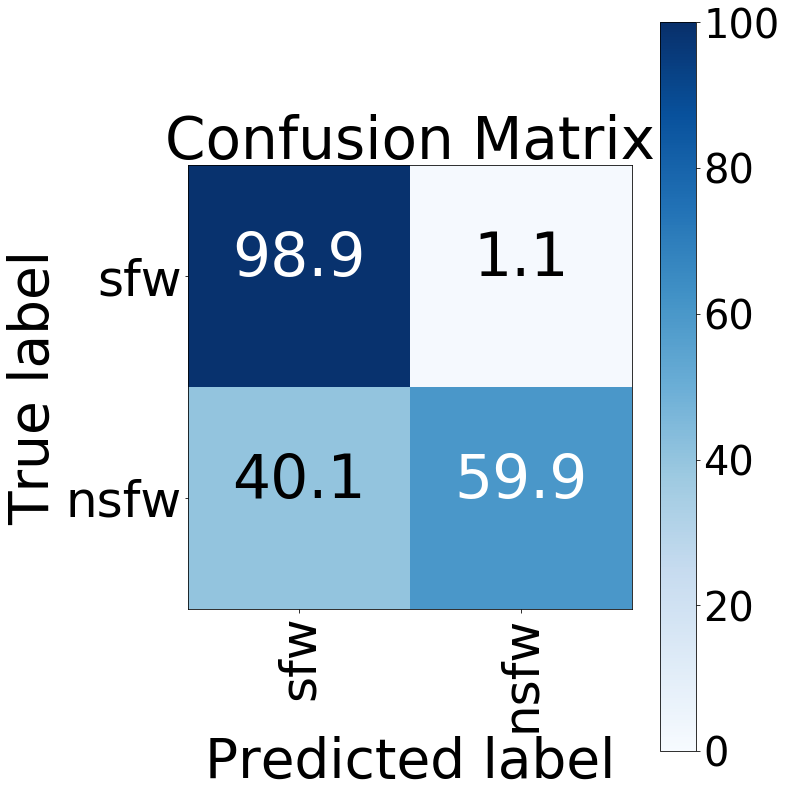

In [14]:
from util import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

classes = ["sfw", "nsfw"]
cm = confusion_matrix(data.y_test_2, y_test_pred)
plot_confusion_matrix(cm, classes, normalize=True, task="nsfw")

In [15]:
from util import get_f1_score

f1_score = get_f1_score(data.y_test_2, y_test_pred)
print(f1_score)

0.836801134535


In [16]:
_ = model.eval(data, sess, split="test")

test accuracy:95.3%
